In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
import glob
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('HousesDataset/HousesInfo.txt', header=None, sep=' ', names=['bedrooms', 'bathrooms', 'area', 'zipcode', 'price'])

In [3]:
data

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [4]:
images = []
for i in data.index.values:
    basepath = os.path.sep.join(['HousesDataset', f"{i+1}_*"])
    images_path = sorted(list(glob.glob(basepath)))
    input_images = []
    for image_path in images_path:
        image = cv2.resize(cv2.imread(image_path), (32, 32))
        input_images.append(image)
    output_images = np.zeros((64, 64, 3), dtype='uint8')
    output_images[0:32, 0:32] = input_images[0]
    output_images[0:32, 32:64] = input_images[1]
    output_images[32:64, 32:64] = input_images[2]
    output_images[32:64, 0:32] = input_images[3]
    images.append(output_images)

In [5]:
images = np.array(images)
images.shape

(535, 64, 64, 3)

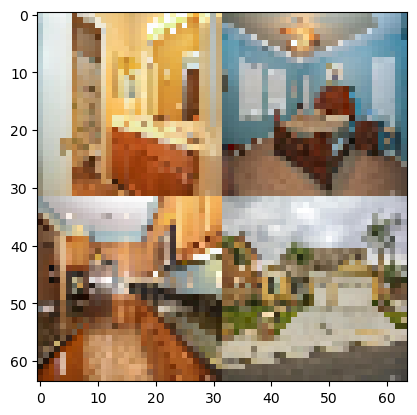

In [6]:
plt.imshow(images[250][..., ::-1])

In [7]:
X_train, X_test, IX_train, IX_test = train_test_split(data, images, random_state=532)

In [8]:
# normalize
max_price = X_train['price'].max()
y_train = X_train['price'] / max_price
y_test = X_test['price'] / max_price

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate ,Conv2D, MaxPool2D, Activation, Dense, Flatten, BatchNormalization, Input, Dropout

In [10]:
input_data = Input(shape=(64, 64, 3))
conv1 = Conv2D(16, (3, 3), padding='same')(input_data)
batchnorm1 = BatchNormalization(axis=-1)(conv1)
max_pool1 = MaxPool2D(pool_size=(2, 2))(batchnorm1)
conv2 = Conv2D(32, (3, 3), padding='same')(max_pool1)
batchnorm2 = BatchNormalization(axis=-1)(conv2)
max_pool2 = MaxPool2D(pool_size=(2, 2))(batchnorm2)
conv3 = Conv2D(64, (3, 3), padding='same')(max_pool2)
batchnorm3 = BatchNormalization(axis=-1)(conv3)
max_pool3 = MaxPool2D(pool_size=(2, 2))(batchnorm3)
flatten = Flatten()(max_pool3)
dense1 = Dense(32, activation='relu')(flatten)
batchnorm4 = BatchNormalization(axis=-1)(dense1)
dropout = Dropout(0.5)(batchnorm4)
dense2 = Dense(16, activation='relu')(dropout)

In [11]:
image_model = Model(input_data, dense2)

In [12]:
image_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128   

In [13]:
standard_scalar = StandardScaler()
csv_data_train = standard_scalar.fit_transform(X_train[['bedrooms', 'bathrooms', 'area']])
csv_data_test = standard_scalar.transform(X_test[['bedrooms', 'bathrooms', 'area']])

In [14]:
# one hotting encdoe
label_binarizer = LabelBinarizer()
label_binarizer.fit(data['zipcode'])
csv_data_train_zipcode = label_binarizer.transform(X_train['zipcode'])
csv_data_test_zipcode = label_binarizer.transform(X_test['zipcode'])

In [15]:
csv_data_train = np.hstack([csv_data_train, csv_data_train_zipcode])
csv_data_test = np.hstack([csv_data_test, csv_data_test_zipcode])

In [16]:
csv_data_train

array([[-1.18233374, -0.66393189, -0.53456569, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18233374, -1.67049782, -0.99902288, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18233374, -0.66393189, -0.96479972, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.54172382,  0.34263404,  0.51250006, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54172382,  1.85248294,  1.38682034, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.4037526 ,  2.3557659 ,  2.03135654, ...,  0.        ,
         0.        ,  0.        ]])

In [17]:
csv_data_train[12]

array([-0.32030496, -0.66393189, -0.6991628 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [18]:
csv_data_train.shape

(401, 52)

In [19]:
csv_data_train.shape[0] + csv_data_test.shape[0]

535

In [20]:
csv_model = Sequential()
csv_model.add(Dense(16, activation='relu', input_dim=52))
csv_model.add(Dropout(0.5))
csv_model.add(Dense(8, activation='relu'))
csv_model.add(Dense(4, activation='relu'))

In [21]:
csv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                848       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
Total params: 1,020
Trainable params: 1,020
Non-trainable params: 0
_________________________________________________________________


In [22]:
combined_tensor = concatenate([image_model.output, csv_model.output])

In [23]:
dense_final_1 = Dense(8, activation='relu')(combined_tensor)
dense_final_2 = Dense(1, activation='linear')(dense_final_1)
final_model = Model(inputs=[csv_model.input, image_model.input], outputs=dense_final_2)

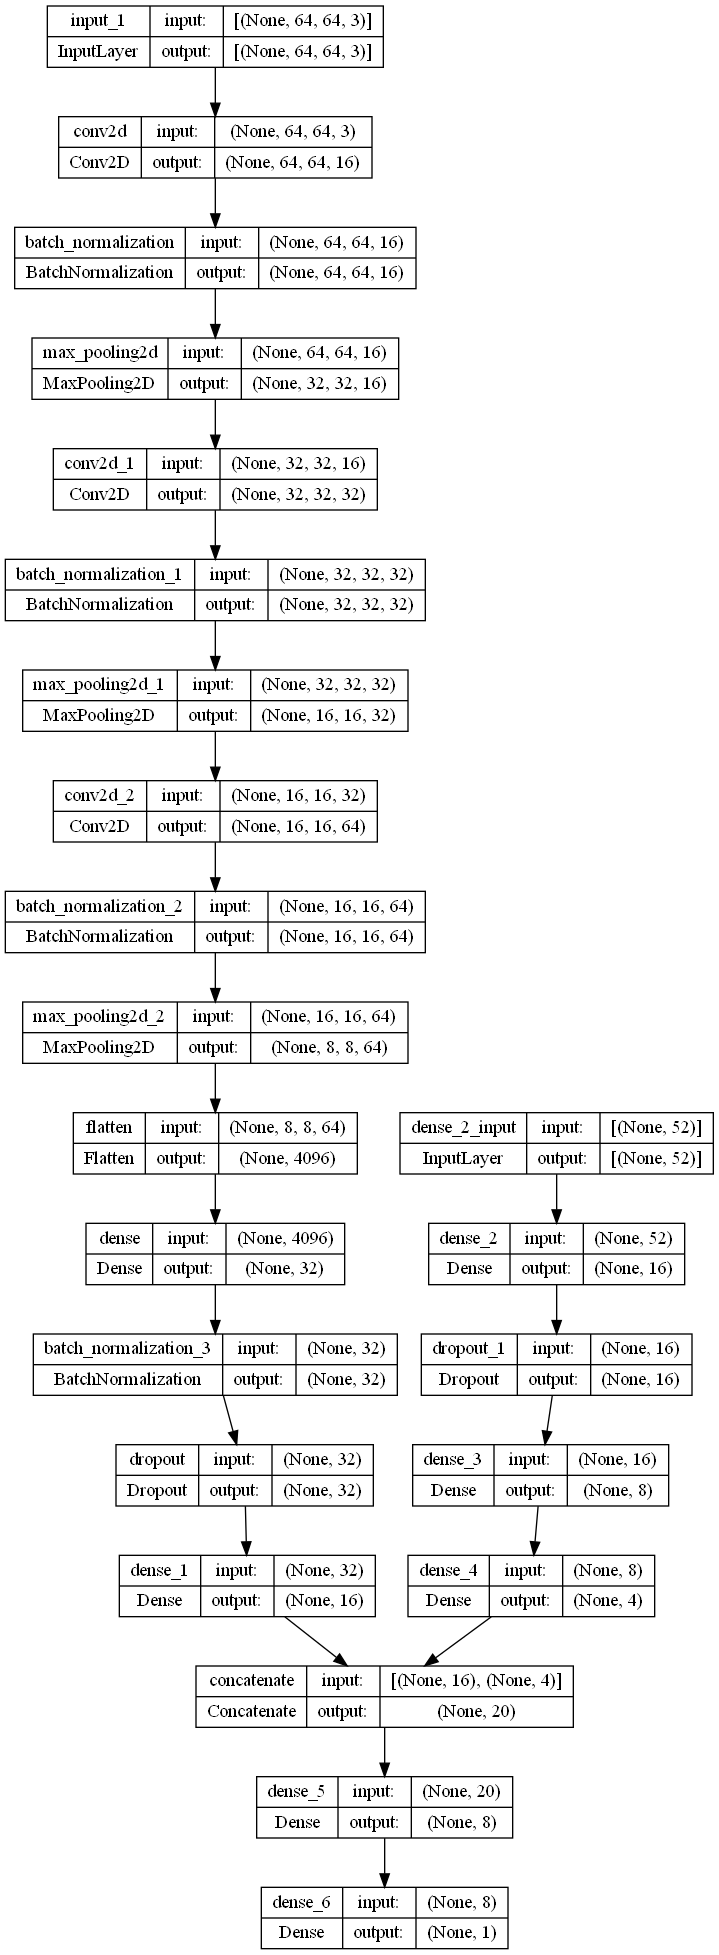

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(final_model, show_shapes=True)

In [26]:
final_model.compile(optimizer='adam',
                   loss='mean_absolute_error',
                   metrics=['accuracy'])

In [27]:
final_model.fit([csv_data_train, IX_train], y_train, validation_data=([csv_data_test, IX_test], y_test), epochs=100, batch_size=10)

Epoch 1/100
41/41 [==============================] - 7s 87ms/step - loss: 0.7016 - accuracy: 0.0000e+00 - val_loss: 6.5165 - val_accuracy: 0.0000e+00
Epoch 2/100
41/41 [==============================] - 3s 74ms/step - loss: 0.2597 - accuracy: 0.0000e+00 - val_loss: 0.7616 - val_accuracy: 0.0000e+00
Epoch 3/100
41/41 [==============================] - 3s 68ms/step - loss: 0.1863 - accuracy: 0.0000e+00 - val_loss: 0.2178 - val_accuracy: 0.0000e+00
Epoch 4/100
41/41 [==============================] - 3s 68ms/step - loss: 0.1613 - accuracy: 0.0000e+00 - val_loss: 0.1992 - val_accuracy: 0.0000e+00
Epoch 5/100
41/41 [==============================] - 3s 69ms/step - loss: 0.1445 - accuracy: 0.0000e+00 - val_loss: 0.1142 - val_accuracy: 0.0000e+00
Epoch 6/100
41/41 [==============================] - 3s 69ms/step - loss: 0.1171 - accuracy: 0.0025 - val_loss: 0.0955 - val_accuracy: 0.0000e+00
Epoch 7/100
41/41 [==============================] - 3s 69ms/step - loss: 0.1122 - accuracy: 0.0000e+00 

41/41 [==============================] - 3s 75ms/step - loss: 0.0298 - accuracy: 0.0000e+00 - val_loss: 0.0320 - val_accuracy: 0.0000e+00
Epoch 56/100
41/41 [==============================] - 3s 76ms/step - loss: 0.0304 - accuracy: 0.0025 - val_loss: 0.0300 - val_accuracy: 0.0000e+00
Epoch 57/100
41/41 [==============================] - 3s 81ms/step - loss: 0.0289 - accuracy: 0.0000e+00 - val_loss: 0.0294 - val_accuracy: 0.0000e+00
Epoch 58/100
41/41 [==============================] - 3s 76ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0291 - val_accuracy: 0.0000e+00
Epoch 59/100
41/41 [==============================] - 3s 75ms/step - loss: 0.0315 - accuracy: 0.0000e+00 - val_loss: 0.0283 - val_accuracy: 0.0000e+00
Epoch 60/100
41/41 [==============================] - 3s 77ms/step - loss: 0.0283 - accuracy: 0.0000e+00 - val_loss: 0.0302 - val_accuracy: 0.0000e+00
Epoch 61/100
41/41 [==============================] - 3s 78ms/step - loss: 0.0307 - accuracy: 0.0000e+00 - val_

In [29]:
predicts = final_model.predict([csv_data_test, IX_test]) * max_price

5/5 [==============================] - 0s 46ms/step


In [30]:
predicted_price = predicts.flatten()    

In [33]:
real_price = y_test.values * max_price

In [32]:
predicted_price

array([ 679122.29551375,  281947.71142304,  216617.31403321,
        814927.4982214 ,  453795.32532394,  238591.8854773 ,
        350831.24541491,  523648.98969233,  635447.59553671,
        484609.35464501,  470010.63284278,  544751.89501047,
       1171574.09203053,  352670.40136456,  472641.3654238 ,
        138591.88066423,  140656.400159  ,  343620.76857686,
        546737.8962487 ,  603422.9709506 ,  796721.91220522,
       1182654.89915013,   95432.67770112,  462012.59475946,
        206667.95106232,  887371.87224627,  474006.55305386,
        783850.41746497,  102957.2493881 ,  102273.7171948 ,
        846924.18968678,  519551.3754636 ,  596196.67261839,
        751146.31971717,  415789.34668005,  637774.64272082,
        521252.1969974 ,  526082.96835423,  328718.18679571,
        758980.25071621,  229183.79218876,   77437.02654541,
        372597.23500907,  660551.61488056,  289036.87559068,
        680502.36625969,  393773.94486964,  932523.84150028,
        888480.46797514,

In [34]:
real_price

array([ 289900.,  550000.,  196000.,  799900.,  534888.,  245000.,
        275000.,  749000.,  521500.,  699900.,  625000.,  679000.,
       1895000.,  139900.,  235000.,   72000.,   77000.,  395000.,
        669472.,  725000., 1199000., 1430000.,  100000.,  229000.,
         94500.,  910000.,  695000.,  750000.,   97500.,   99900.,
        875000.,  559000.,  579500., 1495000.,  664900.,  729000.,
        580000.,  550000.,  999000.,  895000.,  379500.,   63500.,
         65000.,  699999.,  475000., 1188000.,  335000., 1045000.,
       1695000.,  759000.,  106000.,  470000.,  825500.,  547900.,
        578000.,  154500., 2395000.,  185000.,  899000.,  759000.,
        875000.,   59900.,  117000.,  699500.,  448000., 1595000.,
        869000., 1150000., 1229000.,  534977.,  299000.,  196000.,
        409900.,  490000.,  799000.,  689000.,  389900.,  445000.,
        218000.,  429900., 1089000.,  119000.,  589900.,  225000.,
        529000.,  599500.,  495000.,  164900.,  695000.,  2149

In [35]:
different_price = abs(predicted_price - real_price) 

In [36]:
different_price.mean()

160843.68553354402

In [37]:
different_price.std()

224929.39057132922

In [38]:
from sklearn.metrics import r2_score, mean_absolute_error

In [39]:
r2_score(y_pred=predicted_price, y_true=real_price)

0.6014701385424563